## Подготовка данных

Загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

Загрузка файла:

In [2]:
data_autos = pd.read_csv('/datasets/autos.csv')

In [3]:
data_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data_autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Перед нами датафрейм, состоящий из 354369 строк, 16 столбцов (15 признаков и 1 целевой признак). В нем имеются пропущенные значения, а также некоторые лишние признаки для машинного обучения. Заметим, что средняя цена автомобилей 4400 евро, что является очень маленькой суммой, а медиана 2700, значит имеется очень много машин с неадекватной стоимостью. Есть выбросы, например, дата регистрации автомобиля в 1000 году. Почему-то есть нулевой месяц регистрации. А также в таблицу видимо внесли только те автомобили, у которых пробег составляет не более 150000 км.

In [6]:
data_autos['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [7]:
data_autos.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Самая популярная марка - Volkswagen Golf. Большинство машин не находилось в ремонте.

In [8]:
temp = (
    data_autos.groupby(['Brand', 'Model', 'VehicleType'])['Power']
    .count().sort_values(ascending=False))

temp.head()

Brand       Model   VehicleType
volkswagen  golf    sedan          14744
opel        corsa   small          10499
volkswagen  polo    small          10267
bmw         3er     sedan           8087
volkswagen  passat  wagon           7134
Name: Power, dtype: int64

Volkswagen Golf седан лидирует по количеству машин в нашей таблице.

Проверим датасет на дубликаты и удалим их:

In [9]:
data_autos.duplicated().sum()

4

In [10]:
df1 = data_autos[data_autos.duplicated(keep=False)]
df1

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [11]:
#df1 = df1.groupby(df1.columns.tolist()).apply(lambda x: x.index.tolist()).values.tolist()
#print(df1)

In [12]:
df2 = df1.groupby(df1.columns.tolist()).apply(lambda x: x.index.tolist())
df2.to_frame()

,,,,,,,,,,,,,,,,0
DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,
2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57,"[88087, 171088]"
2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15,"[41529, 325651]"
2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21,"[90964, 231258]"
2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54,"[187735, 258109]"


In [13]:
data_autos.drop_duplicates(inplace = True)

Проверим количество пропусков по столбцам:

In [14]:
data_autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [15]:
def searching_gaps(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1).rename(
    columns = {0 : 'Num_Miss_Vallues', 1 : '% of Total Values'})
    mis_val_table = mis_val_table[
        mis_val_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("В выбранном датафрейме всего " + str(df.shape[1]) + " столбцов.\n"      
        "Из них " + str(mis_val_table.shape[0]) +
            " столбцов имеют(ет) пропуски.")
    return mis_val_table

In [16]:
searching_gaps(data_autos)

В выбранном датафрейме всего 16 столбцов.
Из них 5 столбцов имеют(ет) пропуски.


,Num_Miss_Vallues,% of Total Values
NotRepaired,71154,20.1
VehicleType,37490,10.6
FuelType,32895,9.3
Gearbox,19833,5.6
Model,19705,5.6


- Почти 20% процентов автомобилей имеют пропуск в графе "ремонт". Заменим значения на 'unknown', но предполагаю, что владельцы не заполнилнили эту строку, потому что их автомобиль не был в ремонте.
- Тип автомобиля попробуем заполнить по марке и модели. Модель - по марке.

Проверим данные на выбросы (неадекватные значения цены, даты и т.д.)

Выдвину предположение, что 60 лет для машины - это максимальный возраст, при котором она еще сможет завестись.

In [17]:
normal_period = data_autos.loc[(data_autos['RegistrationYear'] >= 1960) & (data_autos['RegistrationYear'] <= 2021)]

In [18]:
outliers = np.round(100 - (len(normal_period) * 100 / len(data_autos)), 3)
print('Процент "ненормальных" лет регистрации = ', outliers)

Процент "ненормальных" лет регистрации =  0.149


Как оказалось, машин с большим количеством лет 0.1%, думаю можно смело удалить.

Рассмотрим дату последней активности пользователя

In [19]:
data_autos['LastSeen'].max()

'2016-04-07 14:58:51'

Получили 2016 год, значит автомобили не могут быть старше этого года.

In [20]:
data_autos = data_autos.loc[(data_autos['RegistrationYear'] >= 1960) & (data_autos['RegistrationYear'] <= 2016)]

Рассмотрим как у нас распределяется цена по разным выборкам:

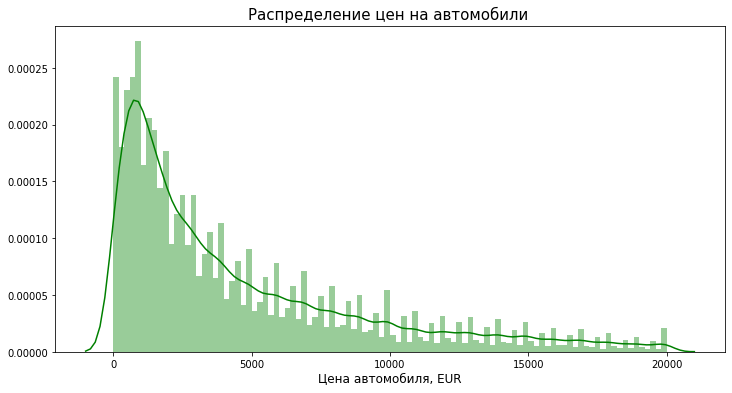

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(data_autos['Price'], bins = 100, kde=True, color='green')
plt.xlabel('Цена автомобиля, EUR', size=12)
plt.title('Распределение цен на автомобили ', size=15);

По графику можно определить, что большая часть автомобилей находится в диапозоне от 0 до 2500 тысяч евро.

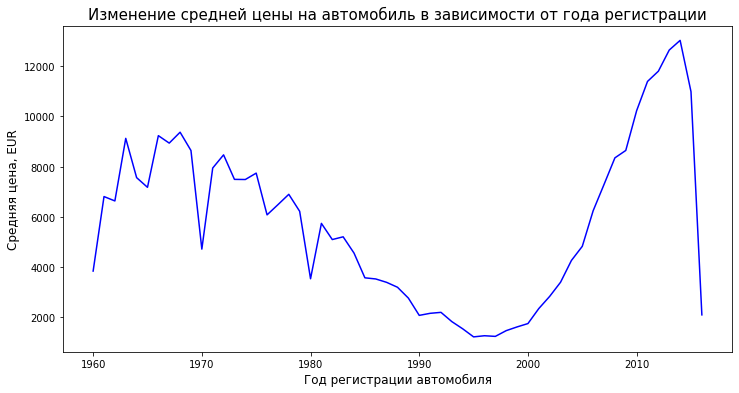

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(x='RegistrationYear', y='Price', data = data_autos.groupby('RegistrationYear', as_index = False)['Price'].mean(),
             color='blue')
plt.xlabel('Год регистрации автомобиля', size=12)
plt.ylabel('Средняя цена, EUR', size=12)
plt.title('Изменение средней цены на автомобиль в зависимости от года регистрации', size=15);

Цена на автомобили в районе 1990-2000 года подозрительно маленькая, а затем сразу идет резкое повышение цен. Возможно это связано с каким-нибудь кризисом или обесцениваем валюты.

В принципе, машина может стоить и 10000 рублей (привет, шаха), поэтому заменим только те строки, у которых в цене стоит 0 на средние значения по модели.

In [23]:
data_autos[data_autos['Price'] == 0].count()

DateCrawled          9939
Price                9939
VehicleType          6996
RegistrationYear     9939
Gearbox              7679
Power                9939
Model                7995
Kilometer            9939
RegistrationMonth    9939
FuelType             6907
Brand                9939
NotRepaired          5077
DateCreated          9939
NumberOfPictures     9939
PostalCode           9939
LastSeen             9939
dtype: int64

**Перейдем к заполнению и удалению пропусков**

1) Заменим пропуски в графе NotRepaired:

In [24]:
data_autos.groupby('Model', as_index = False)['Price'].mean()

,Model,Price
0,100,1792.124088
1,145,826.800000
2,147,2288.209647
3,156,1524.894137
4,159,7039.879808
5,1_reihe,1618.509944
6,1er,9951.907548
7,200,3865.777778
8,2_reihe,3178.643252
9,300c,10031.489209


In [25]:
data_autos['NotRepaired'] = data_autos['NotRepaired'].fillna(value='unknown')

2) Коробка передач

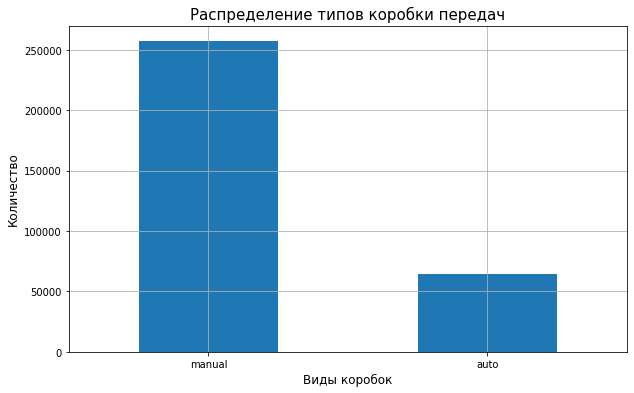

manual    257359
auto       64277
Name: Gearbox, dtype: int64

In [26]:
plt.figure()
fig = data_autos['Gearbox'].value_counts().plot(kind = 'bar', grid=True, figsize=(10,6))
plt.xticks(rotation=0)
plt.xlabel('Виды коробок', size=12)
plt.ylabel('Количество', size=12)
plt.title('Распределение типов коробки передач', size=15);
plt.show()
data_autos['Gearbox'].value_counts()

Механических коробок передач в 4 раза больше, чем "автоматов". В этом признаке 5.6% пропусков.

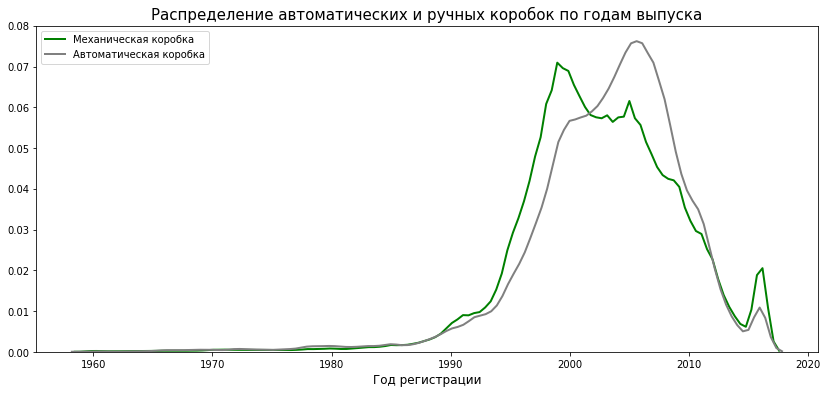

In [27]:
plt.figure(figsize=(14,6))
sns.distplot(data_autos.loc[data_autos['Gearbox']== 'manual', 'RegistrationYear'], hist=False, 
             color='green', kde_kws={"lw": 2, "label": "Механическая коробка"})

sns.distplot(data_autos.loc[data_autos['Gearbox']== 'auto', 'RegistrationYear'], hist=False, 
             color='gray', kde_kws={"lw": 2, "label": "Автоматическая коробка"})
plt.xlabel('Год регистрации', size=12)
plt.title('Распределение автоматических и ручных коробок по годам выпуска', size=15);

Начиная с 2000 года, автоматических коробок передач стало больше, но не настолько, чтобы все новые автомобили с пропусками заменить ею. Поэтому заменим пропуски на 'unknown'.

In [28]:
data_autos['Gearbox'] = data_autos['Gearbox'].fillna(value='unknown')

3) Модель автомобиля

In [29]:
data_autos.groupby(['Brand'])['Model'].count().to_frame().sort_values(by = 'Model')

,Model
Brand,
sonstige_autos,0
lada,204
rover,388
lancia,425
daewoo,470
trabant,481
jaguar,486
saab,498
land_rover,526


In [30]:
data_autos['Model'].value_counts()

golf                  27610
other                 23729
3er                   19223
polo                  12450
corsa                 11935
astra                 10335
passat                 9841
a4                     9695
c_klasse               8113
5er                    7721
e_klasse               6638
a3                     5761
focus                  5631
fiesta                 5550
a6                     5425
2_reihe                4698
transporter            4664
twingo                 4645
fortwo                 4189
vectra                 4097
a_klasse               3919
mondeo                 3501
1er                    3418
3_reihe                3370
clio                   3361
touran                 3261
punto                  3137
zafira                 2853
megane                 2792
ka                     2598
ibiza                  2561
lupo                   2466
octavia                2066
fabia                  2031
cooper                 1901
clk                 

Получили неизвестный бренд sonstige_autos. Это бренд, которого не было в списке возможных на сайте. Очевидно, что мы не знаем какие там модели, поэтому заменим на 'other'. Этот тип модели является вторым по популярности, видимо многие модели не были доступны на сайте.

In [31]:
data_autos.loc[data_autos['Brand']=='sonstige_autos', 'Model'] = data_autos.loc[data_autos['Brand']=='sonstige_autos', 'Model'].fillna('other')

Остальные пропуски заменим на привычный нам 'unknown'

In [32]:
data_autos['Model'] = data_autos['Model'].fillna(value='unknown')

4) Тип кузова

Можно предположить, что тип кузова не будет сильно влиять на цену, поэтому можно выбрать любой способ запонения. У одинаковых моделей будет одинаковый тип кузова, поэтому cоздаlbv словарь с наиболее часто встречающими значениями типа кузова, сгруппированных по моделям автомобилей. Заполняем этими значениями пропуски.

In [33]:
data_autos['VehicleType'].value_counts()

sedan          91342
small          79792
wagon          65153
bus            28765
convertible    20178
coupe          16137
suv            11961
other           3245
Name: VehicleType, dtype: int64

In [34]:
vt_dict = dict(data_autos.groupby(['Model'])['VehicleType'].apply(lambda x: x.mode()[0]))

data_autos['VehicleType'] = data_autos['VehicleType'].fillna(data_autos['Model'].map(vt_dict))

5) Тип топлива

In [35]:
data_autos['FuelType'].value_counts()

petrol      209780
gasoline     96291
lpg           5158
cng            542
hybrid         224
other          192
electric        89
Name: FuelType, dtype: int64

В списке есть интересные типы топлива: электрические, гибридные. Но их количество ничтожно мало. Опять же заполним пропуски по моделям, предположу что раньше у модели автомобиля был только один вариант выбора топлива, а не как в нынешнее время.

In [36]:
fuel_dict = data_autos.groupby(['Model'])['FuelType'].apply(lambda x: x.mode()[0])
data_autos['FuelType'] = data_autos['FuelType'].fillna(data_autos['Model'].map(fuel_dict))

Изучим значения в признаке Power, предположу, что он будет сильно влиять на цену автомобиля.

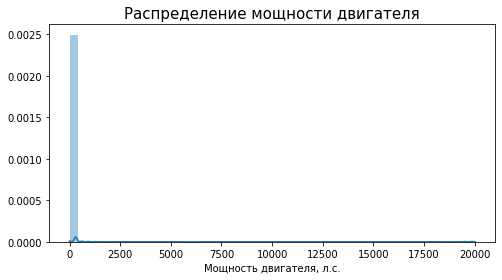

0      36258
75     22803
60     15163
150    14148
101    12731
140    12473
90     12195
116    11565
105     9957
170     9872
Name: Power, dtype: int64

In [37]:
plt.figure(figsize=(8,4))
sns.distplot(data_autos['Power'])
plt.xlabel('Мощность двигателя, л.с.')
plt.title('Распределение мощности двигателя',size=15);
plt.show()
data_autos['Power'].value_counts().head(10)

Около 10% строк имеют 0 мощности, даже у лошади она 1). Заменим эти значения, а также уберем выбросы, например 20000.

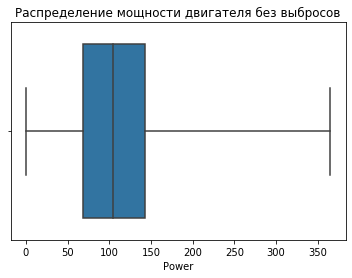

In [38]:
sns.boxplot(data_autos['Power'], showfliers=False, whis=3)
plt.title('Распределение мощности двигателя без выбросов');

Построив график с усами с размахом в три сигмы (куда входят практически все значения), выяснили что максимальный порог примерно 360 л.с. Однако на практике имеются гоночные и спортивные автомобили, у которых двигатель имеет это 500 до 1000 л.с.

In [39]:
data_autos[data_autos['Power'] >=1000].head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,unknown,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,unknown,150000,0,petrol,honda,unknown,2016-04-02 00:00:00,0,21509,2016-04-04 09:15:26
9664,2016-03-14 20:06:19,2599,bus,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00,0,57520,2016-04-01 19:16:33
19078,2016-03-20 11:00:08,0,small,2016,manual,1111,ibiza,150000,0,petrol,seat,yes,2016-03-20 00:00:00,0,42277,2016-03-20 11:00:08
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20 00:00:00,0,21376,2016-03-23 02:48:53


Я просмотрел мощности некоторых автомобилей, и вот что нашел:

- В 1999 году появилась модификация OPC, Astra с атмосферным мотором 2.0 выдавала 160 лошадиных сил.
- Toyota Corolla (1.3 MT, 88 л.c.) Седан: 9 поколение (E120, E130) (2000 – 2004)
- Volkswagen Lupo (1.0 MT, 50 л.c.)

Получается, что мощность дигателя увеличена в 10 или 100 раз, поэтому попробуем написать функцию по устранению этой ошибки. Строки с мощностью больше чем 10000 удалим, их не так много. Также заменим 0 на медианные значения по моделям.

In [40]:
data_autos[data_autos['Power'] >=10000].count()

DateCrawled          43
Price                43
VehicleType          43
RegistrationYear     43
Gearbox              43
Power                43
Model                43
Kilometer            43
RegistrationMonth    43
FuelType             43
Brand                43
NotRepaired          43
DateCreated          43
NumberOfPictures     43
PostalCode           43
LastSeen             43
dtype: int64

In [41]:
data_autos = data_autos.drop(data_autos.loc[data_autos['Power']>=10000].index)

In [42]:
def pow_norm(row):
    
    power = row['Power']
    
    if 370 <= power <= 3700:
        return power / 10
    if 3701 <= power <= 9999:
        return power / 100
    if power == 0:
        return np.nan
    else:
        return power

In [43]:
data_autos['Power'] = data_autos.apply(pow_norm, axis=1)

In [44]:
data_autos.iloc[1814]

DateCrawled          2016-03-08 14:38:34
Price                                  0
VehicleType                        small
RegistrationYear                    1993
Gearbox                           manual
Power                                 45
Model                              corsa
Kilometer                         150000
RegistrationMonth                      2
FuelType                          petrol
Brand                               opel
NotRepaired                      unknown
DateCreated          2016-03-08 00:00:00
NumberOfPictures                       0
PostalCode                         45892
LastSeen             2016-03-14 17:19:31
Name: 1899, dtype: object

In [45]:
data_autos['Power'].isna().sum()

36258

In [46]:
data_autos['Power'] = data_autos.groupby('Model')['Power'].transform(lambda x: x.fillna(value=x.median()))

In [47]:
data_autos = data_autos.drop(data_autos[data_autos['Power'].isna()].index)
data_autos['Power'] = data_autos['Power'].astype('int')

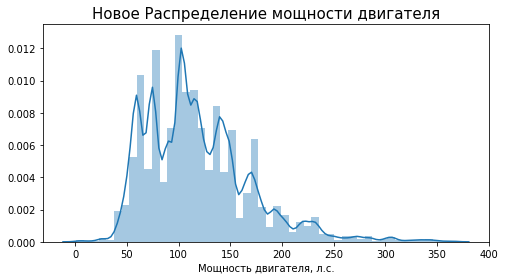

In [48]:
plt.figure(figsize=(8,4))
sns.distplot(data_autos['Power'])
plt.xlabel('Мощность двигателя, л.с.')
plt.title('Новое Распределение мощности двигателя',size=15);

Конечно замена идеальной не получилась, но хотя бы мощность двигателя адекватная.

In [49]:
data_autos.loc[data_autos['Price']<100].count()

DateCrawled          12346
Price                12346
VehicleType          12346
RegistrationYear     12346
Gearbox              12346
Power                12346
Model                12346
Kilometer            12346
RegistrationMonth    12346
FuelType             12346
Brand                12346
NotRepaired          12346
DateCreated          12346
NumberOfPictures     12346
PostalCode           12346
LastSeen             12346
dtype: int64

Также я только что решил удалить строки, где цена ниже 100 евро.

In [50]:
def price_norm(row):
    price = row['Price']
    if price < 100:
        return np.nan
    else:
        return price

In [51]:
data_autos['Price'] = data_autos.apply(price_norm, axis=1)

In [52]:
data_autos = data_autos.dropna(axis='index', how='any', subset=['Price'])

In [53]:
data_autos[data_autos['Price'] < 100].count()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

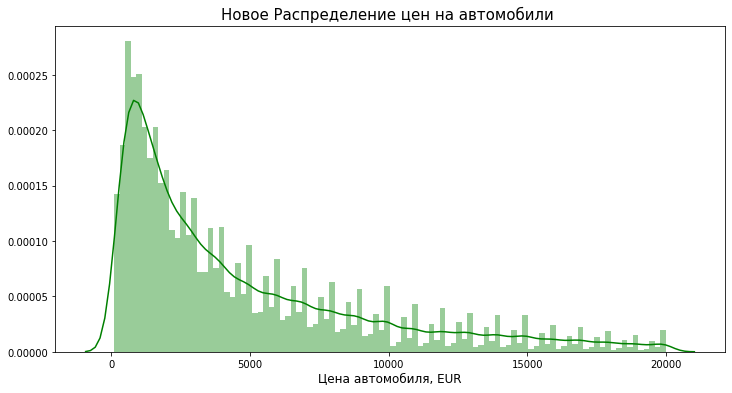

In [54]:
plt.figure(figsize=(12,6))
sns.distplot(data_autos['Price'], bins = 100, kde=True, color='green')
plt.xlabel('Цена автомобиля, EUR', size=12)
plt.title('Новое Распределение цен на автомобили ', size=15);

In [55]:
data_autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Чуть не забыл проверить признаки на корреляцию:

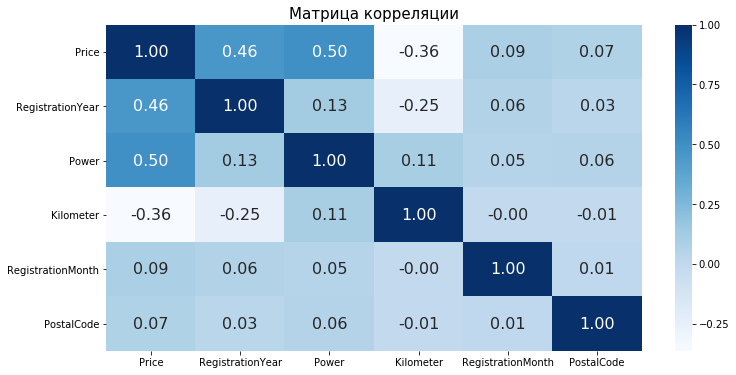

In [56]:
plt.figure(figsize=(12,6))
sns.heatmap(data_autos.drop('NumberOfPictures', axis = 1).corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16})
plt.title('Матрица корреляции', size=15);

Сильной зависиомти нет, самая большая у мощности двигателя и цены, но она не критична, чтобы ее удалять, и в добавок это один из самых важных признаков.

### Вывод

На данном этапе проета был проведен большой анализ данных с последующей обработкой. Большинство пропущенных значений было заменено средним или медианным значением по модели. Основной сегмент автомобилей находится в диапозоне от 0 до 2000 евро, что означает что машины не самого высокого качества. В датасете присутствуют лишние столбцы, на следующем шаге они будут удалены. Переходим к обучению моделей.

## Обучение моделей

Как много раз говорилось ранее, оставим только нужные нам признаки.

In [57]:
useless_cols_1 = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [58]:
data_autos = data_autos.drop(useless_cols_1, axis=1)

In [59]:
data_autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480.0,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown
1,18300.0,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800.0,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500.0,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [60]:
data_ohe = pd.get_dummies(data_autos, drop_first=True)

In [61]:
RND_ST = 12345

In [62]:
features = data_ohe.drop('Price', axis=1)
target = data_ohe['Price']

In [63]:
features.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,1993,101,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,

In [64]:
target.head()

0      480.0
1    18300.0
2     9800.0
3     1500.0
4     3600.0
Name: Price, dtype: float64

Разделим датасет на Обучающую, валидационную, тестовую выборки. А также соединим обучающую и валидационную для итогового анализа.

In [65]:
X_train, temp_x, y_train, temp_y = train_test_split(features, target, test_size=0.4, random_state=RND_ST)

In [66]:
X_valid, X_test, y_valid, y_test = train_test_split(temp_x, temp_y, test_size=0.5, random_state=RND_ST)

In [67]:
X_temp = pd.concat([X_train, X_valid], ignore_index=True)
Y_temp = pd.concat([y_train, y_valid], ignore_index=True)

In [68]:
print(X_train.shape[0], 
      X_valid.shape[0],
      X_test.shape[0], 
      X_temp.shape[0])

196213 65404 65405 261617


Отмасштабируем данные:

In [69]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_temp[numeric] = scaler.transform(X_temp[numeric])

Создадим модель-балванку, чтобы проверять модели на адекватность.

In [70]:
%%time

dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_valid)
rmse_dummy = np.around(np.sqrt(mean_squared_error(y_valid, y_pred)),3)
print('RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = {}'.format(rmse_dummy))
print()

RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = 4538.215

CPU times: user 424 µs, sys: 3.66 ms, total: 4.08 ms
Wall time: 6.38 ms


Модель очень сильно ошибается, на целых 4500 евро, при условии что у нас многие автомобили стоят до 2000 евро, это очень много. Единственный плюс - работает крайне быстро.

In [71]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits = 6, shuffle = True, random_state = RND_ST)


Обучим следующие модели: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM.

### 2.1 Линейная регрессия

In [72]:
%%time

line_reg_model = LinearRegression().fit(X_train, y_train)
predictions = line_reg_model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
rmse_train = mse ** 0.5
print("RMSE Линейной регрессии на обучающей выборке:", rmse_train)

predictions_valid = line_reg_model.predict(X_valid)
mse_valid = mean_squared_error(y_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
print("RMSE Линейной регрессии на валидационной выборке:", rmse_valid)

RMSE Линейной регрессии на обучающей выборке: 2678.625212853981
RMSE Линейной регрессии на валидационной выборке: 2679.9410121275087
CPU times: user 19 s, sys: 7.72 s, total: 26.7 s
Wall time: 26.7 s


### 2.2 Случайный лес

In [74]:
'''forest = RandomForestRegressor(random_state = RND_ST)
    
forest_params = {'n_estimators': range(50, 81, 10),
                 'max_depth': range(7,12)}

forest_grid = GridSearchCV(forest, forest_params, cv=3)

forest_grid.fit(X_train, y_train)

print("RMSE для случайного леса составляет ", forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)''';

In [75]:
%%time

rf_regr = RandomForestRegressor(max_depth = 14, n_estimators = 45, random_state = RND_ST).fit(X_train, y_train)
       
predictions = rf_regr.predict(X_train)
mse = mean_squared_error(y_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = rf_regr.predict(X_valid)
mse_valid = mean_squared_error(y_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
    
print("RMSE случайного леса на обучающей  выборке", rmse_train)
print("RMSE случайного леса на валидационной выборке", rmse_valid)
print()

RMSE случайного леса на обучающей  выборке 1522.4893975803416
RMSE случайного леса на валидационной выборке 1710.6389874271044

CPU times: user 2min 51s, sys: 188 ms, total: 2min 51s
Wall time: 2min 52s


### 2.3 Дерево решений

In [76]:
'''%%time
for depth in range(10, 20):
    regr = DecisionTreeRegressor(max_depth=depth, random_state = RND_ST).fit(X_train, y_train)
       
    predictions = regr.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = regr.predict(X_valid)
    mse_valid = mean_squared_error(y_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("max_depth =", depth, ":")
    print("RMSE Дерева решений на обучающей  выборке", rmse)
    print("RMSE Дерева решений на валидационной выборке", rmse_valid)
    print()'''

'%%time\nfor depth in range(10, 20):\n    regr = DecisionTreeRegressor(max_depth=depth, random_state = RND_ST).fit(X_train, y_train)\n       \n    predictions = regr.predict(X_train)\n    mse = mean_squared_error(y_train, predictions)\n    rmse = mse ** 0.5\n    \n    predictions_valid = regr.predict(X_valid)\n    mse_valid = mean_squared_error(y_valid, predictions_valid)\n    rmse_valid = mse_valid ** 0.5\n    \n    print("max_depth =", depth, ":")\n    print("RMSE Дерева решений на обучающей  выборке", rmse)\n    print("RMSE Дерева решений на валидационной выборке", rmse_valid)\n    print()'

Лучшим параметром будет 16 деревьев, будем использовать его на тесте.

In [77]:
%%time
regr = (DecisionTreeRegressor(max_depth=16, random_state=RND_ST)
        .fit(X_train, y_train)
       )
predictions = regr.predict(X_train)
mse = mean_squared_error(y_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = regr.predict(X_valid)
mse_valid = mean_squared_error(y_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
    
print("RMSE Дерева решений на обучающей  выборке", rmse_train)
print("RMSE Дерева решений на валидационной выборке", rmse_valid)
print()

RMSE Дерева решений на обучающей  выборке 1454.2944072585572
RMSE Дерева решений на валидационной выборке 1849.9991307938196

CPU times: user 5.94 s, sys: 455 ms, total: 6.4 s
Wall time: 6.43 s


### 2.4. LightGBMRegressor

In [78]:
'''%%time
parameters = {'max_depth': np.arange(13, 15),
              'n_estimators': np.arange(37, 45)
             }

gs_lgbm = GridSearchCV(LGBMRegressor(random_state = RND_ST), 
                  parameters,
                  cv=kf,
                  scoring = 'neg_mean_squared_error')

# обучение
gs_lgbm.fit(X_train, y_train)
# просмотр лучших параметров
gs_lgbm.best_params_'''

"%%time\nparameters = {'max_depth': np.arange(13, 15),\n              'n_estimators': np.arange(37, 45)\n             }\n\ngs_lgbm = GridSearchCV(LGBMRegressor(random_state = RND_ST), \n                  parameters,\n                  cv=kf,\n                  scoring = 'neg_mean_squared_error')\n\n# обучение\ngs_lgbm.fit(X_train, y_train)\n# просмотр лучших параметров\ngs_lgbm.best_params_"

In [79]:
#gs_lgbm.best_score_

In [81]:
%%time
model_lgb = LGBMRegressor(max_depth=13, n_estimators=44,random_state=RND_ST).fit(X_train, y_train)
            

predictions = model_lgb.predict(X_train)
mse = mean_squared_error(y_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = model_lgb.predict(X_valid)
mse_valid = mean_squared_error(y_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
print("RMSE LightGBM на обучающей  выборке", rmse_train)
print("RMSE LightGBM на валидационной выборке", rmse_valid)

RMSE LightGBM на обучающей  выборке 1810.6800216442216
RMSE LightGBM на валидационной выборке 1792.2655670701204
CPU times: user 3min 16s, sys: 2.41 s, total: 3min 18s
Wall time: 3min 20s


### 2.5 CatBoost

Для этой модели не обязательно кодировать категориальные признаки

In [82]:
features = data_autos.drop('Price', axis=1)
target = data_autos['Price']

In [83]:
X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
    features, target, test_size=0.2, random_state=RND_ST)

 
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(
    X_train_val_c, y_train_val_c, test_size=0.25, random_state=RND_ST)

X_temp_c = pd.concat([X_train_c, X_valid_c], ignore_index=True)
Y_temp_c = pd.concat([y_train_c, y_valid_c], ignore_index=True)
print(X_train_c.shape[0], X_valid_c.shape[0], X_test_c.shape[0], X_temp_c.shape[0])

196212 65405 65405 261617


In [84]:
X_train_c.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [85]:
X_train_c.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
339291,sedan,1989,manual,26,601,40000,petrol,trabant,no
247217,small,1995,manual,75,2_reihe,90000,petrol,peugeot,no
62296,wagon,2001,manual,100,golf,150000,gasoline,volkswagen,no
153221,sedan,1999,manual,170,e_klasse,150000,gasoline,mercedes_benz,no
306494,coupe,2008,manual,177,1er,125000,gasoline,bmw,no


In [86]:
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [87]:
train_pool = Pool(X_train_c, 
                  y_train_c, 
                  cat_features=cat_feat)

valid_pool = Pool(X_valid_c, 
                  y_valid_c, 
                  cat_features=cat_feat)

temp_pool = Pool(X_temp_c, 
                  Y_temp_c, 
                  cat_features=cat_feat)

test_pool = Pool(X_test_c, 
                 cat_features=cat_feat)

In [88]:
cbr = CatBoostRegressor(depth=6, 
                        learning_rate=1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        random_state=RND_ST, 
                        iterations=500)

In [89]:
%%time
cbr.fit(train_pool)
predictions = cbr.predict(X_train_c)
mse = mean_squared_error(y_train_c, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = cbr.predict(X_valid_c)
mse_valid = mean_squared_error(y_valid_c, predictions_valid)
rmse_valid = mse_valid ** 0.5
print("RMSE CatBoost на обучающей  выборке", rmse_train)
print("RMSE CatBoost на валидационной выборке", rmse_valid)

0:	learn: 2702.4859039	total: 835ms	remaining: 6m 56s
50:	learn: 1708.7275484	total: 34.8s	remaining: 5m 6s
100:	learn: 1628.6322092	total: 1m 8s	remaining: 4m 30s
150:	learn: 1589.6107293	total: 1m 42s	remaining: 3m 56s
200:	learn: 1560.8626183	total: 2m 17s	remaining: 3m 24s
250:	learn: 1538.6323550	total: 2m 50s	remaining: 2m 49s
300:	learn: 1517.7016687	total: 3m 25s	remaining: 2m 15s
350:	learn: 1499.9243407	total: 4m	remaining: 1m 42s
400:	learn: 1483.1114689	total: 4m 36s	remaining: 1m 8s
450:	learn: 1468.8379138	total: 5m 10s	remaining: 33.7s
499:	learn: 1456.0820702	total: 5m 44s	remaining: 0us
RMSE CatBoost на обучающей  выборке 1491.9616844901736
RMSE CatBoost на валидационной выборке 1668.683847867894
CPU times: user 5min 20s, sys: 28.1 s, total: 5min 48s
Wall time: 5min 51s


Создадим таблицу с результатами для наглядности результатов

In [90]:
res = {
    'model_name':pd.Series(['Линейная регрессия','Случайный лес', 'Дерево решений', 'LightGBM','CatBoost']),
    'time_spent':pd.Series([21.8,166,6.7,7.66,249]),
    'rmse_train':pd.Series([2678,1522.5,1454.3,1810.3,1492]), 
    'rmse_valid':pd.Series([2680,1710.6,1850,1792.3,1668.7]),
    'time on fit':pd.Series([0,0,0,0,0]),
    'time on ':pd.Series([0,0,0,0,0]),
    'rmse_test':pd.Series([0,0,0,0,0])}

In [91]:
results = pd.DataFrame(res)
results

,model_name,time_spent,rmse_train,rmse_valid,time on fit,time on,rmse_test
0,Линейная регрессия,21.80,2678.0,2680.0,0,0,0
1,Случайный лес,166.00,1522.5,1710.6,0,0,0
2,Дерево решений,6.70,1454.3,1850.0,0,0,0
3,LightGBM,7.66,1810.3,1792.3,0,0,0
4,CatBoost,249.00,1492.0,1668.7,0,0,0


## Анализ моделей

Обучим заново наши модели на объединенной выборке из train+valid, и проверим предикты на тестовой выборке:

In [92]:
%%time 

line_reg_model = LinearRegression().fit(X_temp, Y_temp)

CPU times: user 23.4 s, sys: 9.85 s, total: 33.2 s
Wall time: 33.8 s


In [93]:
%%time 

predictions = line_reg_model.predict(X_test)

CPU times: user 106 ms, sys: 73.2 ms, total: 179 ms
Wall time: 189 ms


In [94]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("RMSE Линейной регрессии на тестовой выборке:", rmse)

RMSE Линейной регрессии на тестовой выборке: 2675.306330879027


In [95]:
%%time
regr = DecisionTreeRegressor(max_depth=16, random_state=RND_ST).fit(X_temp, Y_temp)

CPU times: user 8.06 s, sys: 243 ms, total: 8.3 s
Wall time: 8.34 s


In [96]:
%%time
predictions = regr.predict(X_test)

CPU times: user 123 ms, sys: 46.8 ms, total: 169 ms
Wall time: 179 ms


In [97]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("RMSE Дерева решений на тестовой выборке:", rmse)

RMSE Дерева решений на тестовой выборке: 1811.7952046354555


In [98]:
%%time
rf_regr = RandomForestRegressor(max_depth = 14, n_estimators = 45, random_state = RND_ST).fit(X_temp, Y_temp) 

CPU times: user 3min 46s, sys: 0 ns, total: 3min 46s
Wall time: 3min 48s


In [99]:
%%time
predictions = rf_regr.predict(X_test)

CPU times: user 827 ms, sys: 0 ns, total: 827 ms
Wall time: 842 ms


In [100]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("RMSE Случайного леса на тестовой выборке:", rmse)

RMSE Случайного леса на тестовой выборке: 1718.3929876692278


In [101]:
%%time
model_lgb = LGBMRegressor(max_depth=13, n_estimators=44,random_state=RND_ST).fit(X_temp, Y_temp)

CPU times: user 2min 58s, sys: 1.31 s, total: 3min
Wall time: 3min 1s


In [102]:
%%time
predictions = model_lgb.predict(X_test)

CPU times: user 622 ms, sys: 94.9 ms, total: 717 ms
Wall time: 709 ms


In [103]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("RMSE LightGBM на тестовой выборке:", rmse)

RMSE LightGBM на тестовой выборке: 1802.4681867368818


In [104]:
%%time
cbr = CatBoostRegressor(depth=6, learning_rate=1, loss_function = 'RMSE', verbose=50, random_state=RND_ST, iterations=500).fit(temp_pool)

0:	learn: 2735.1348756	total: 998ms	remaining: 8m 18s
50:	learn: 1699.3800740	total: 44.7s	remaining: 6m 33s
100:	learn: 1636.7789419	total: 1m 27s	remaining: 5m 47s
150:	learn: 1595.0048151	total: 2m 10s	remaining: 5m
200:	learn: 1568.6468696	total: 2m 55s	remaining: 4m 21s
250:	learn: 1545.6295986	total: 3m 39s	remaining: 3m 37s
300:	learn: 1524.9082593	total: 4m 23s	remaining: 2m 54s
350:	learn: 1509.0490240	total: 5m 6s	remaining: 2m 10s
400:	learn: 1494.3313831	total: 5m 51s	remaining: 1m 26s
450:	learn: 1483.5973438	total: 6m 35s	remaining: 43s
499:	learn: 1471.5595375	total: 7m 20s	remaining: 0us
CPU times: user 6min 48s, sys: 33.9 s, total: 7min 22s
Wall time: 7min 26s


In [105]:
%%time
predictions = cbr.predict(X_test_c)

CPU times: user 860 ms, sys: 49.6 ms, total: 910 ms
Wall time: 1.09 s


In [106]:
mse = mean_squared_error(y_test_c, predictions)
rmse = mse ** 0.5
print("RMSE CatBoost на тестовой выборке:", rmse)

RMSE CatBoost на тестовой выборке: 1624.3747653808084


In [107]:
res = {
    'model_name':pd.Series(['Линейная регрессия','Случайный лес', 'Дерево решений', 'LightGBM','CatBoost']),
    'time_spent':pd.Series([21.3,188,7.4,6.98,249]),
    'rmse_train':pd.Series([2742.6,1573.8,1499.1,1297.4,1499.1]), 
    'rmse_valid':pd.Series([2764.5,1828.4,1970.6,1902.2,1732]),
    'time on fit':pd.Series([28.1,223,8.35,7.3,420]),
    'time on predict, ms':pd.Series([185,754,162,697,769]),
    'rmse_test':pd.Series([2675,1718,1812,1802,1624])}

In [108]:
results = pd.DataFrame(res)
results

,model_name,time_spent,rmse_train,rmse_valid,time on fit,"time on predict, ms",rmse_test
0,Линейная регрессия,21.30,2742.6,2764.5,28.10,185,2675
1,Случайный лес,188.00,1573.8,1828.4,223.00,754,1718
2,Дерево решений,7.40,1499.1,1970.6,8.35,162,1812
3,LightGBM,6.98,1297.4,1902.2,7.30,697,1802
4,CatBoost,249.00,1499.1,1732.0,420.00,769,1624


In [109]:
temp = results.copy().sort_values(by=['rmse_test'])
temp

,model_name,time_spent,rmse_train,rmse_valid,time on fit,"time on predict, ms",rmse_test
4,CatBoost,249.00,1499.1,1732.0,420.00,769,1624
1,Случайный лес,188.00,1573.8,1828.4,223.00,754,1718
3,LightGBM,6.98,1297.4,1902.2,7.30,697,1802
2,Дерево решений,7.40,1499.1,1970.6,8.35,162,1812
0,Линейная регрессия,21.30,2742.6,2764.5,28.10,185,2675


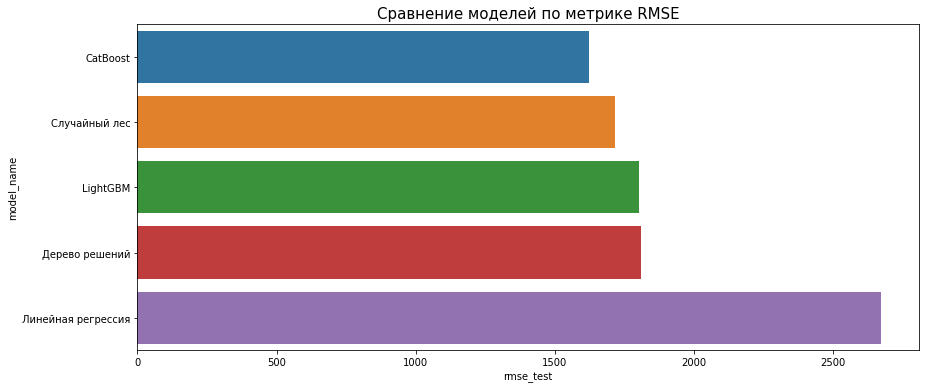

In [110]:
plt.figure(figsize=(14,6))
sns.barplot(y=temp['model_name'], x=temp['rmse_test'], orient='h')
plt.title('Cравнение моделей по метрике RMSE', size=15);

In [111]:
temp = results.copy().sort_values(by=['time on fit'])

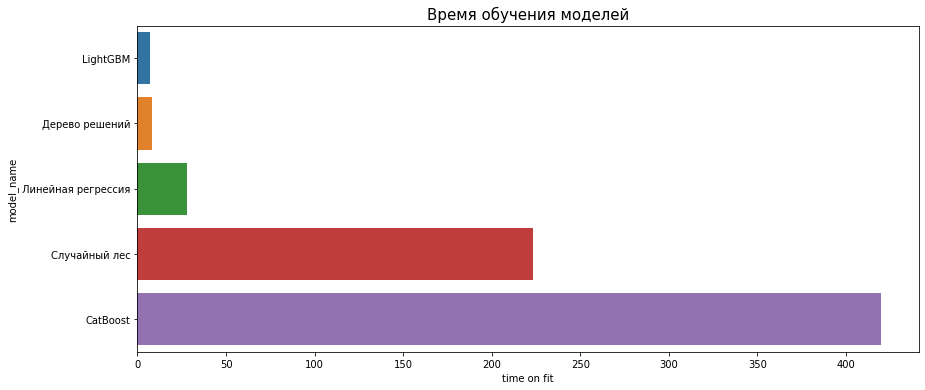

In [112]:
plt.figure(figsize=(14,6))
sns.barplot(y=temp['model_name'], x=temp['time on fit'], orient='h')
plt.title('Время обучения моделей', size=15);

In [113]:
temp = results.copy().sort_values(by=['time on predict, ms'])

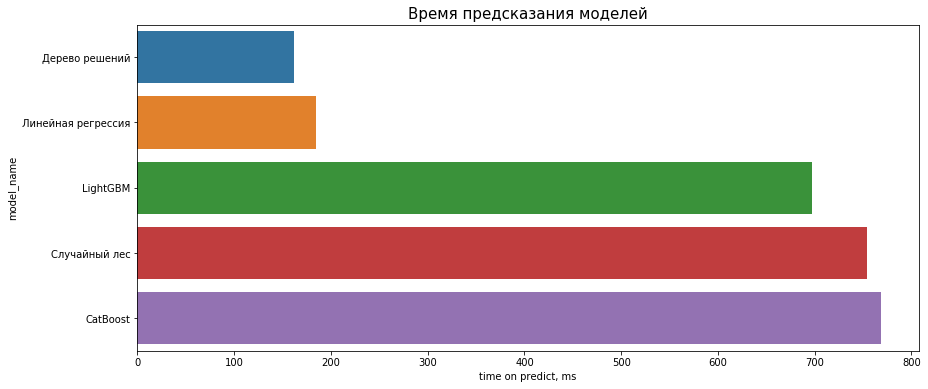

In [114]:
plt.figure(figsize=(14,6))
sns.barplot(y=temp['model_name'], x=temp['time on predict, ms'], orient='h')
plt.title('Время предсказания моделей', size=15);

Посмотрим влияние признаков на результаты моделей на примере CatBoost, LightGBM и RandomForest.

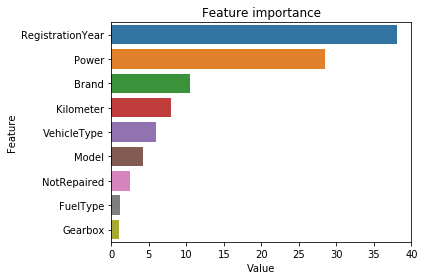

In [115]:
feature_importance = cbr.feature_importances_
feature_list = list(X_temp_c.columns)
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_list)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

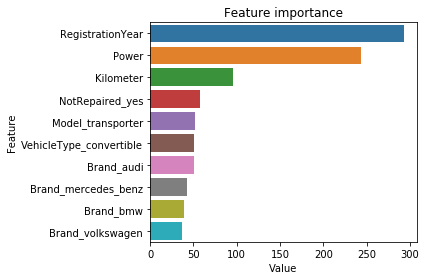

In [116]:
feature_importance = model_lgb.feature_importances_
feature_list = list(X_temp.columns)
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_list)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

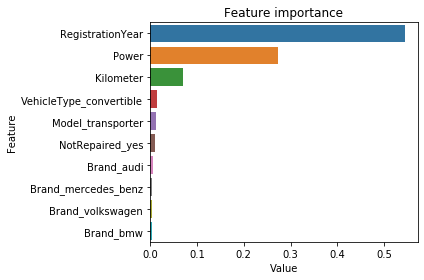

In [117]:
feature_importance = rf_regr.feature_importances_
feature_list = list(X_temp.columns)
feature_imp = pd.DataFrame(sorted(zip(feature_importance, feature_list)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

# Вывод

В данном проекте была поставлена задача построение модели, которая будет предсказывать цену автомобиля. Думаю можно с уверенностью сказать, что задача выполнена. Однако, данные, которые были предоставлены, имеют посредственный характер: имеется очень большое количество пропусков, пристуствуют дубликаты. Очень многие значения не соответствуют логике. Думаю отделу по сбору данных нужно работать получше. 

В работе были протестированы 5 моделей, все их них показали средние результаты. Наилучший показатель RMSE имеет модель CatBoost с результатом 1743. Однако эта модель обучается долго. Самой быстрой по времени обучения оказалась модель LightGM - её время обучения и предсказания заняло 7.3 секунды. По трретьему критерию - времени предсказания модели лидирует модель Случайного дерева. Она выдает прогнозы за 162 мс. Линейная регрессия полностью провалилась на тесте, показав плохие результаты по rmse. Не стоит забывать, про случайный лес, который чем-то похож на CatBoost - чуть меньше обучается, но и чуть хуже результаты. В целом заказчику нужно выбрать самый важный для него параметр и, исходя из этого, выбрать модель. 

Также были рассмотрены самые важные признаки для моделей. Единолично победи признак "Год регистарции", за ним идут "Мощность двигателя" и Пробег". Брэнд и марка не сильно влияют на цену, видимо из-за того, что БУшные автомобили стоят примерно одинаково, независимо от марки. Так в признаке "год регистрации" пропусков не было, то стоит уделить влияние на мощность двигателя, там было очень многь пропусков и нелогичных "нулей" и "10000 л.с.". Поэтому к сбору мощности надо отнестись серьезно.